In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
from torch.utils.data import DataLoader, random_split, Subset,Dataset
import matplotlib
import cv2
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
from PIL import Image
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import PIL
path = '/kaggle/input/amia-public-challenge-2024/train/train/'

In [30]:
csv_path = '/kaggle/input/amia-public-challenge-2024/train.csv'
data_o = pd.read_csv(csv_path)

In [31]:
data_o['image_id'] = data_o['image_id']+'.png'
data_o.drop(['rad_id','x_min','y_min','x_max','y_max'], axis=1, inplace=True)

In [32]:
data_o=data_o.drop_duplicates()

In [55]:
data_o

,image_id,class_name,class_id
0,bM8C97htulC9fHKIDurJHquCXr1KZuug.png,No finding,14
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m.png,Aortic enlargement,0
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w.png,Consolidation,4
3,vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4.png,No finding,14
4,EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z.png,No finding,14
...,...,...,...
45842,CdQTR8TktHNjigilD7NfN3wd3gMjSP67.png,Infiltration,6
45853,GaYTbGReD23PmqVGquBZuCldNgxI1chG.png,Other lesion,9
45873,8RQmdJy5QggUaFfskOKmv0MAA6qwaU1B.png,Aortic enlargement,0
45912,VB9qIgH0NlPf97mkeDOWPZPWrrTeXCOP.png,Cardiomegaly,3


In [58]:
one_hot_encoded = pd.get_dummies(data_o['class_id'],dtype='float32')

In [59]:
data = data_o.join(one_hot_encoded)

In [60]:
data

,image_id,class_name,class_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bM8C97htulC9fHKIDurJHquCXr1KZuug.png,No finding,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m.png,Aortic enlargement,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w.png,Consolidation,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4.png,No finding,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z.png,No finding,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45842,CdQTR8TktHNjigilD7NfN3wd3gMjSP67.png,Infiltration,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45853,GaYTbGReD23PmqVGquBZuCldNgxI1chG.png,Other lesion,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45873,8RQmdJy5QggUaFfskOKmv0MAA6qwaU1B.png,Aortic enlargement,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45912,VB9qIgH0NlPf97mkeDOWPZPWrrTeXCOP.png,Cardiomegaly,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Group by image path and aggregate the one-hot encoded class columns
grouped_data = data.groupby('image_id').agg({col: 'max' for col in one_hot_encoded.columns}).reset_index()

one_hot_columns = one_hot_encoded.columns
grouped_data['one_hot_encoded'] = grouped_data[one_hot_columns].values.tolist()

In [62]:
# Drop the individual one-hot encoded class columns if not needed
grouped_data = grouped_data[['image_id', 'one_hot_encoded']]

# Save the processed data to a new CSV file
processed_csv_path = './ohe_train.csv'
grouped_data.to_csv(processed_csv_path, index=False)

# Display the resulting DataFrame
print(grouped_data)

                                  image_id  \
0     00JgsY3R0C6VQrT7VDFcoqW2J7dOfULr.png   
1     010IQw6wElqZvRtUvjEuGMA5DFEOnzGc.png   
2     010ZwwgPngrLSwFtbfzgbHIMtgjbgVR2.png   
3     01ZExlNggWNuY5WGKO5LzWE611Q1y6yN.png   
4     02N1zTmv56PPjf935D9FCMU6tnRzcIw2.png   
...                                    ...   
8568  zwlq8uw7B18q79tfBv4lKmHOppluY9NL.png   
8569  zxH7yrSxiFOOKAEQrAqbaq5u4kTYU0V6.png   
8570  zxMhtmrG8a8nHIsVYtc7JUY3vIK5HBM5.png   
8571  zxSOd7RHAkKIN3AT0UqUTSsV733x5Hai.png   
8572  zzuxT296dLKpCcrVIIrBP7NfPKsaqKlT.png   

                                        one_hot_encoded  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3     [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  
...                                                 ...  
8568  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

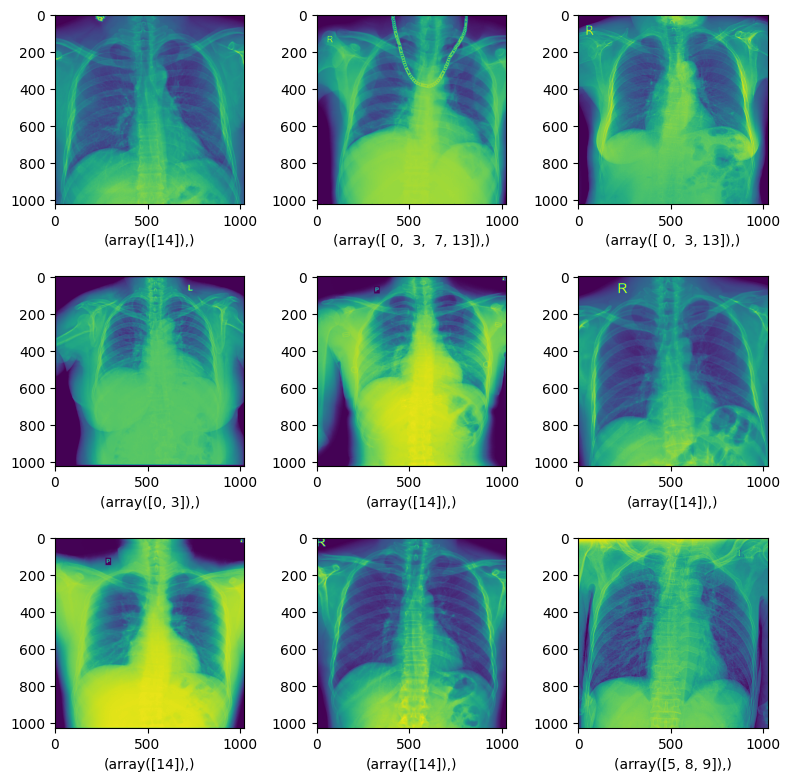

In [63]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(len(grouped_data), size=9)):
    im = PIL.Image.open(os.path.join(path,grouped_data['image_id'][k]))
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    index = np.array(grouped_data['one_hot_encoded'][k]).nonzero()
    plt.xlabel(index)
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [64]:
class CustomDataset(Dataset):
    def __init__(self, img_ids,one_hot_labels, transform=None):
        self.img_ids = img_ids
        self.one_hot_labels = one_hot_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(path,self.img_ids[idx])
        image = Image.open(img_name).convert('L')
        labels = np.array(self.one_hot_labels[idx], dtype=np.float32)
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

In [65]:
transform1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure image is grayscale
    transforms.Resize((128, 128)),                # Resize to 128x128
    transforms.ToTensor(),                        # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

In [66]:
dataset = CustomDataset(grouped_data['image_id'],grouped_data['one_hot_encoded'], transform=transform1)

In [81]:
random.seed(0)
num_images = len(grouped_data)
random_indices = random.sample(range(len(dataset)), num_images)
split = int(0.9 * len(random_indices))
train_ind,test_ind = random_indices[:split],random_indices[split:]

In [82]:
# Create a DataLoader for the random subset
train_random_sampler = torch.utils.data.SubsetRandomSampler(train_ind)
test_random_sampler = torch.utils.data.SubsetRandomSampler(test_ind)

# Create a DataLoader
dataloader_train = DataLoader(dataset, batch_size=25,sampler = train_random_sampler)
dataloader_test = DataLoader(dataset, batch_size=25,sampler = test_random_sampler)

In [83]:
# Load the pre-trained ResNet model
model = models.densenet121(weights=None)

In [84]:
# Modify the final layer for multi-label classification
num_classes = len(dataset[0][1])  # Number of classes based on the one-hot encoded labels
model.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [86]:
from torch.optim import Adam

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    #print(epoch)

    with tqdm(total=len(dataloader_train), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for images, labels in dataloader_train:
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
            predictions = torch.sigmoid(outputs) > 0.5
            
            # Calculate number of correct predictions
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.numel()  # Number of elements in the batch (number of labels)

            # Update the progress bar
            pbar.set_postfix(loss=loss.item(), accuracy=(correct_predictions / total_samples) * 100)
            pbar.update(1)

    epoch_loss = running_loss / len(dataloader_train.dataset)
    epoch_accuracy = (correct_predictions / total_samples) * 100
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch 1/10: 100%|██████████| 309/309 [02:37<00:00,  1.96it/s, accuracy=89, loss=0.309]  


Epoch [1/10], Loss: 0.3737, Accuracy: 88.99%


Epoch 2/10: 100%|██████████| 309/309 [02:52<00:00,  1.79it/s, accuracy=90.2, loss=0.238]


Epoch [2/10], Loss: 0.2649, Accuracy: 90.17%


Epoch 3/10: 100%|██████████| 309/309 [02:38<00:00,  1.95it/s, accuracy=90.6, loss=0.187]


Epoch [3/10], Loss: 0.2281, Accuracy: 90.61%


Epoch 4/10: 100%|██████████| 309/309 [02:38<00:00,  1.95it/s, accuracy=90.9, loss=0.269]


Epoch [4/10], Loss: 0.2111, Accuracy: 90.88%


Epoch 5/10: 100%|██████████| 309/309 [02:37<00:00,  1.97it/s, accuracy=91.1, loss=0.241]


Epoch [5/10], Loss: 0.1994, Accuracy: 91.11%


Epoch 6/10: 100%|██████████| 309/309 [02:37<00:00,  1.96it/s, accuracy=91.4, loss=0.223]


Epoch [6/10], Loss: 0.1919, Accuracy: 91.40%


Epoch 7/10: 100%|██████████| 309/309 [02:38<00:00,  1.96it/s, accuracy=91.6, loss=0.205]


Epoch [7/10], Loss: 0.1840, Accuracy: 91.57%


Epoch 8/10: 100%|██████████| 309/309 [02:38<00:00,  1.95it/s, accuracy=91.8, loss=0.192]


Epoch [8/10], Loss: 0.1784, Accuracy: 91.77%


Epoch 9/10: 100%|██████████| 309/309 [02:36<00:00,  1.97it/s, accuracy=91.9, loss=0.219]


Epoch [9/10], Loss: 0.1721, Accuracy: 91.94%


Epoch 10/10: 100%|██████████| 309/309 [02:36<00:00,  1.97it/s, accuracy=92.1, loss=0.264]

Epoch [10/10], Loss: 0.1672, Accuracy: 92.15%


In [87]:
torch.save(model.state_dict(), 'model.pth')

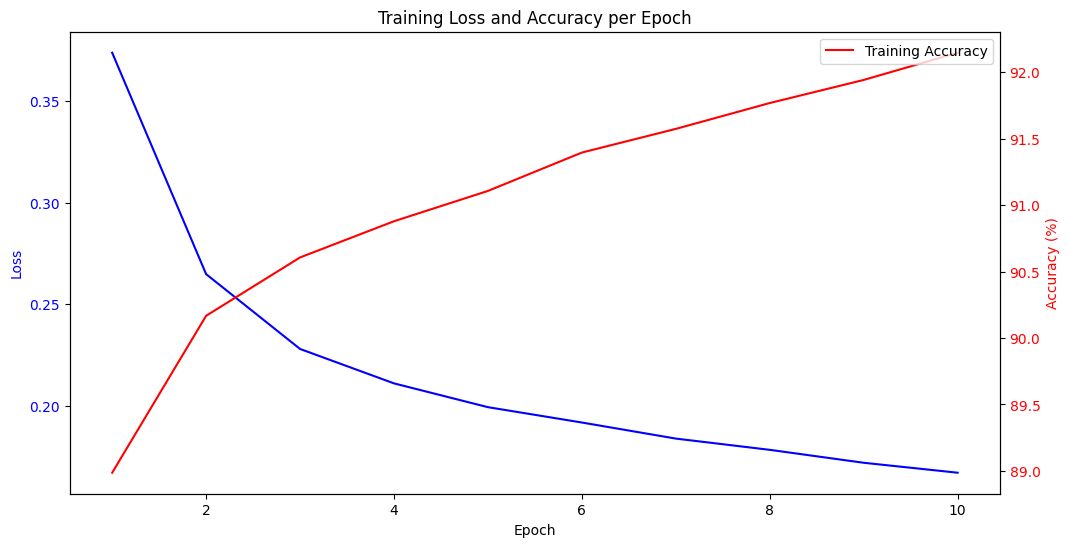

In [91]:
plt.figure(figsize=(12, 6))

# Plot loss on the primary y-axis
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss', color='b')
plt.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for accuracy
ax2 = plt.gca().twinx()
ax2.plot(range(1, num_epochs + 1), train_accuracies, 'r-', label='Training Accuracy')
ax2.set_ylabel('Accuracy (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add titles and legends
plt.title('Training Loss and Accuracy per Epoch')
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [89]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloader_test:
        outputs = model(inputs.to(device))
        all_preds.append(torch.sigmoid(outputs))
        all_labels.append(labels.to(device))

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

In [90]:
threshold = 0.5
binary_preds = (all_preds > threshold).float()

# Calculate accuracy
correct_predictions = torch.eq(binary_preds, all_labels).float()
accuracy = correct_predictions.sum().item() / correct_predictions.numel()

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 91.04%
